<a href="https://colab.research.google.com/github/manasvifulluke/Major-Project-/blob/main/MrjorProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import nltk
nltk.download('punkt')
import wordcloud

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
data = pd.read_excel(r'/content/final.xlsx', dtype={'StockCode':str})

In [3]:
#print(data.head(3))
#print(data.shape)

In [4]:
# Checking and Removing null values.
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

<ipython-input-4-b28ec6da3c06>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))


,Unnamed: 0.1,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Segment,Score,SegmentType
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

<ipython-input-5-7e7125a2895a>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))


,Unnamed: 0.1,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Segment,Score,SegmentType
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#checking and removing duplicate data
data.duplicated().sum()
data.drop_duplicates(inplace=True)

In [ ]:
#data.duplicated().sum()

In [7]:
#data analysis
'''plt.figure(figsize=(14,6))
plt.plot(data.groupby(['Country']).groups.keys(), data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()'''

'plt.figure(figsize=(14,6))\nplt.plot(data.groupby([\'Country\']).groups.keys(), data.groupby([\'Country\'])[\'CustomerID\'].count())\nplt.xticks(rotation = 90, fontsize = 14)\nplt.title("Number of transanctions done for each country")\nplt.ylabel("No. of trans.")\nplt.xlabel("Country")\nplt.show()'

In [8]:
#info = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
#info

In [9]:
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3520,11749,759


In [10]:
#no of items bought in single transaction
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})

In [11]:
#df[:10].sort_values('CustomerID')

In [12]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))

In [13]:
#df.head()

In [14]:
# Looking at cancelled transanctions in original data.
#data.sort_values('CustomerID')[:5]
for index, col in df.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) & (data['Description'] == col[2])].shape[0] == 0:
        #print(index, df.loc[index])
        #print("There are some transanctions for which counterpart does not exist")
        break
df_cleaned = data.copy(deep=True)
df_cleaned['QuatityCancelled'] = 0
entry_to_remove = []; doubtfull_entry = []

In [15]:
for index, col in data.iterrows():
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()

# Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)

    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)

    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [16]:
#print("Entry to remove {}".format(len(entry_to_remove)))
#print("Doubtfull Entry {}".format(len(doubtfull_entry)))

In [17]:
# Deleting these entries :
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'DOT', 'PADS'],
      dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
DOT               -> DOTCOM POSTAGE                     
PADS              -> PADS TO MATCH ALL CUSHIONS         


In [19]:
df_cleaned['QuantityCancelled'] = np.nan_to_num(df_cleaned['QuantityCancelled'])
df_cleaned.head()

,Unnamed: 0.1,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Segment,Score,SegmentType,QuatityCancelled,QuantityCancelled
0,9,9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047,United Kingdom,344,11,Loyal Customers,0,0.0
1,10,10,536367,22745,POPPY'S PLAYHOUSE BEDROOM,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,344,11,Loyal Customers,0,0.0
2,11,11,536367,22748,POPPY'S PLAYHOUSE KITCHEN,6,2010-12-01 08:34:00,2.10,13047,United Kingdom,344,11,Loyal Customers,0,0.0
3,12,12,536367,22749,FELTCRAFT PRINCESS CHARLOTTE DOLL,8,2010-12-01 08:34:00,3.75,13047,United Kingdom,344,11,Loyal Customers,0,0.0
4,13,13,536367,22310,IVORY KNITTED MUG COSY,6,2010-12-01 08:34:00,1.65,13047,United Kingdom,344,11,Loyal Customers,0,0.0


In [20]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,Unnamed: 0.1,Unnamed: 0,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Segment,Score,SegmentType,QuatityCancelled,QuantityCancelled,TotalPrice
25088,72274,72274,542237,84558A,3D DOG PICTURE PLAYING CARDS,12,2011-01-26 14:30:00,2.95,12347,Iceland,444,12,Best Customers,0,0.0,35.4
5177,14962,14962,537626,22497,SET OF 2 TINS VINTAGE BATHROOM,4,2010-12-07 14:57:00,4.25,12347,Iceland,444,12,Best Customers,0,0.0,17.0
5176,14961,14961,537626,22494,EMERGENCY FIRST AID TIN,12,2010-12-07 14:57:00,1.25,12347,Iceland,444,12,Best Customers,0,0.0,15.0
5175,14960,14960,537626,84997D,PINK 3 PIECE POLKADOT CUTLERY SET,6,2010-12-07 14:57:00,3.75,12347,Iceland,444,12,Best Customers,0,0.0,22.5
5174,14959,14959,537626,84997B,RED 3 PIECE RETROSPOT CUTLERY SET,6,2010-12-07 14:57:00,3.75,12347,Iceland,444,12,Best Customers,0,0.0,22.5


In [21]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

In [22]:
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [23]:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12347,537626,711.79,2010-12-07 14:57:00.000000000
1,12347,542237,475.39,2011-01-26 14:29:59.999999744
2,12347,549222,636.25,2011-04-07 10:43:00.000000000
3,12347,556201,382.52,2011-06-09 13:01:00.000000000
4,12347,562032,584.91,2011-08-02 08:48:00.000000000
5,12347,573511,1294.32,2011-10-31 12:25:00.000000000


In [24]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

In [25]:
'''plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()'''

'plt.rc(\'font\', weight=\'bold\')\nf, ax = plt.subplots(figsize=(11, 6))\ncolors = [\'yellowgreen\', \'gold\', \'wheat\', \'c\', \'violet\', \'royalblue\', \'firebrick\']\nlabels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]\nsizes = count_price\nexplode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]\nax.pie(sizes, explode = explode, labels = labels, colors = colors,\n       autopct = lambda x:\'{:1.0f}%\'.format(x) if x > 1 else \'\',\n       shadow = False, startangle = 0)\nax.axis(\'equal\')\nf.text(0.5, 1.01, "Distribution of order amounts", ha = \'center\', fontsize = 18)\nplt.show()'

In [26]:
is_noun = lambda pos:pos[:2] == 'NN'

In [30]:
def keywords_inventory(dataframe, colonne = 'Description'):
    import nltk
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0

    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]

        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1


    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)

            category_keys.append(clef)
            keywords_select[s] = clef

        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]

    #print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [31]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [32]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [33]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

In [34]:
'''list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

liste = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()'''

'list_products = []\nfor k, v in count_keywords.items():\n    word = keywords_select[k]\n    list_products.append([word, v])\n    \nliste = sorted(list_products, key = lambda x:x[1], reverse=True)\n\nplt.rc(\'font\', weight=\'normal\')\nfig, ax = plt.subplots(figsize=(7, 25))\ny_axis = [i[1] for i in liste[:125]]\nx_axis = [k for k,i in enumerate(liste[:125])]\nx_label = [i[0] for i in liste[:125]]\nplt.xticks(fontsize=15)\nplt.yticks(fontsize=13)\nplt.yticks(x_axis, x_label)\nplt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)\nax.barh(x_axis, y_axis, align=\'center\')\nax = plt.gca()\nax.invert_yaxis()\n\nplt.title("Word Occurance", bbox={\'facecolor\':\'k\', \'pad\':5}, color=\'w\', fontsize = 25)\nplt.show()'

In [35]:
# Preserving important words :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])

list_products.sort(key = lambda x:x[1], reverse=True)
#print("Number of preserved words : ", len(list_products))

In [36]:
threshold = [0, 1, 2, 3, 5, 10]

In [37]:
# Getting the description.
liste_produits = df_cleaned['Description'].unique()

In [38]:
# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))

<ipython-input-38-f6fad74629b4>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
<ipython-input-38-f6fad74629b4>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
<ipython-input-38-f6fad74629b4>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using

In [39]:
label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])

    label_col.append(col)
    X.loc[:, col] = 0

<ipython-input-39-7f58c8e3f047>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<ipython-input-39-7f58c8e3f047>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<ipython-input-39-7f58c8e3f047>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, col] = 0
<ipy

In [40]:
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0

    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1

In [41]:
#print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')

In [42]:
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
        #print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [44]:
matrix = X.values

In [45]:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)


For n_clusters :  3 The average silhouette_score is :  0.10749500655981897
For n_clusters :  4 The average silhouette_score is :  0.13284148480352004
For n_clusters :  5 The average silhouette_score is :  0.1518034177856435
For n_clusters :  6 The average silhouette_score is :  0.1490341438366893
For n_clusters :  7 The average silhouette_score is :  0.1529599553572409
For n_clusters :  8 The average silhouette_score is :  0.159338096784812
For n_clusters :  9 The average silhouette_score is :  0.15249052172943325


In [46]:
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

pd.Series(clusters).value_counts()

For n_clusters :  5 The average silhouette_score is :  0.1515171001640709


2    996
1    921
0    631
3    576
4    568
dtype: int64

In [47]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    '''mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)

    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10

    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i

        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)

        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))

        y_lower = y_upper + 10

from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)'''

In [48]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurance) in list_products]

In [49]:
occurance = [dict() for _ in range(n_clusters)]

In [50]:
# Creating data for printing word cloud.
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [51]:
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [52]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]

    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

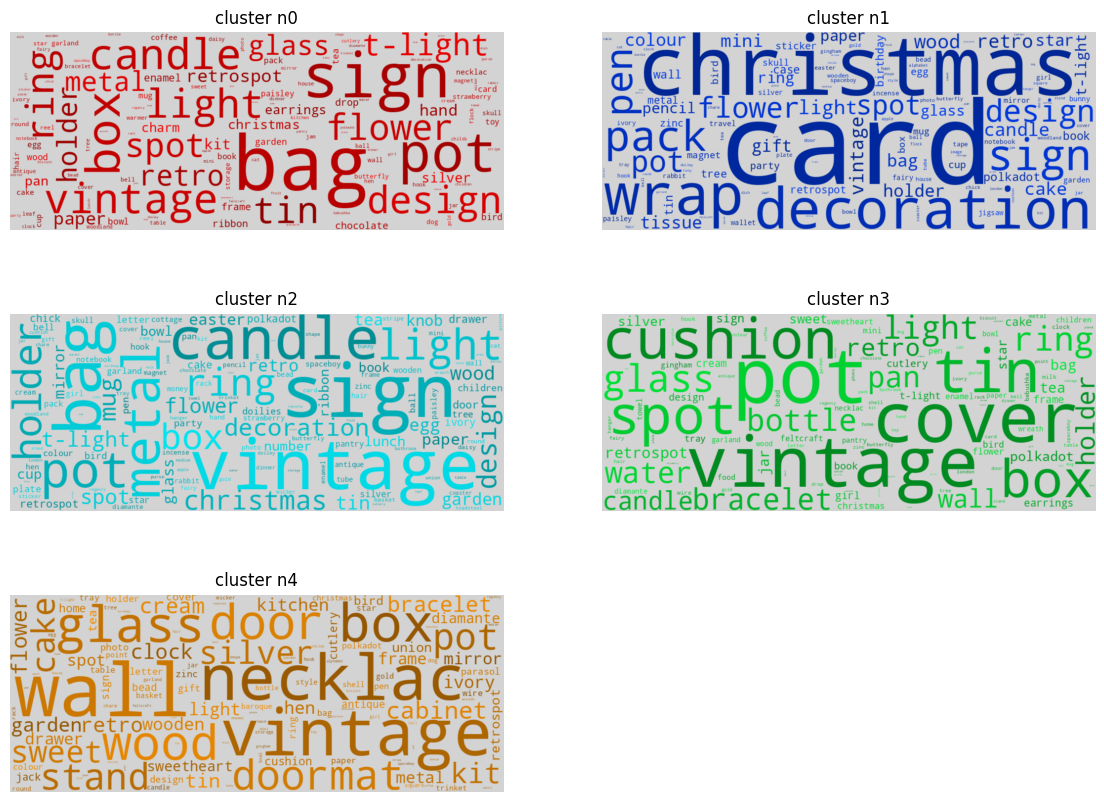

In [53]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

In [54]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

In [55]:
corresp = dict()

In [56]:
for key, val in zip(liste_produits, clusters):
    corresp[key] = val

In [57]:
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536367,ASSORTED COLOUR BIRD ORNAMENT,2
1,536367,POPPY'S PLAYHOUSE BEDROOM,0
2,536367,POPPY'S PLAYHOUSE KITCHEN,0
3,536367,FELTCRAFT PRINCESS CHARLOTTE DOLL,3
4,536367,IVORY KNITTED MUG COSY,2
5,536367,BOX OF 6 ASSORTED COLOUR TEASPOONS,3
6,536367,BOX OF VINTAGE JIGSAW BLOCKS,4
7,536367,BOX OF VINTAGE ALPHABET BLOCKS,4
8,536367,HOME BUILDING BLOCK WORD,4
9,536367,LOVE BUILDING BLOCK WORD,4


In [58]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)


df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536367,ASSORTED COLOUR BIRD ORNAMENT,2,0.0,0.0,54.08,0.0,0.00
1,536367,POPPY'S PLAYHOUSE BEDROOM,0,12.6,0.0,0.00,0.0,0.00
2,536367,POPPY'S PLAYHOUSE KITCHEN,0,12.6,0.0,0.00,0.0,0.00
3,536367,FELTCRAFT PRINCESS CHARLOTTE DOLL,3,0.0,0.0,0.00,30.0,0.00
4,536367,IVORY KNITTED MUG COSY,2,0.0,0.0,9.90,0.0,0.00
5,536367,BOX OF 6 ASSORTED COLOUR TEASPOONS,3,0.0,0.0,0.00,25.5,0.00
6,536367,BOX OF VINTAGE JIGSAW BLOCKS,4,0.0,0.0,0.00,0.0,14.85
7,536367,BOX OF VINTAGE ALPHABET BLOCKS,4,0.0,0.0,0.00,0.0,19.90
8,536367,HOME BUILDING BLOCK WORD,4,0.0,0.0,0.00,0.0,17.85
9,536367,LOVE BUILDING BLOCK WORD,4,0.0,0.0,0.00,0.0,17.85


In [59]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

In [60]:
# percentage spent on each product category
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price[col] = temp[col]

In [61]:
# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [62]:
# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]
import datetime
set_entrainment = basket_price[basket_price['InvoiceDate'] < pd.Timestamp(2011, 10, 1)]
set_test = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp(2011, 10, 1)]
basket_price = set_entrainment.copy(deep = True)
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

In [63]:
for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100

In [64]:
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172,2790.86,14.524555,11.173617,29.105724,32.408290,12.787815
1,12359,3,547.50,1803.11,1153.310,3459.93,10.901955,3.985052,9.916386,15.019090,60.177518
2,12362,5,303.76,829.99,510.908,2554.54,21.498978,5.787343,34.424985,17.343631,20.945063
3,12380,2,607.55,626.01,616.780,1233.56,43.411751,7.052758,22.325627,12.569312,14.640553
4,12381,1,1227.39,1227.39,1227.390,1227.39,22.145365,8.455340,23.602930,10.522328,35.274037


In [65]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

In [66]:
first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

In [67]:
test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

In [68]:
transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']
transanctions_per_user[:5]
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].values

No. of Customers with single purchase : 43/739   (5.82%)


In [69]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [   9.20703654  234.78759134 1114.84807848  543.41320825   22.79862583
   13.16859813   25.08083927   16.98187046   21.97999301]


In [70]:
# Checking the amount of variance explained :
'''fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()'''

'fig, ax = plt.subplots(figsize=(14, 5))\nsns.set(font_scale=1)\nplt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = \'mid\', label = \'Cummulative Variance Explained\')\nsns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = \'g\',\n            label = \'Individual Variance Explained\')\nplt.xlim(0, 10)\nplt.xticks(rotation = 45, fontsize = 14)\nax.set_xticklabels([s if int(s.get_text())%2 == 0 else \'\' for s in ax.get_xticklabels()])\n\nplt.ylabel("Explained Variance", fontsize = 14)\nplt.xlabel("Principal Components", fontsize = 14)\nplt.legend(loc = \'upper left\', fontsize = 13)\nplt.show()'

In [71]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)


For n_clusters :  3 The average silhouette_score is :  0.170139132791591
For n_clusters :  4 The average silhouette_score is :  0.18656423505522068
For n_clusters :  5 The average silhouette_score is :  0.19296857272846785
For n_clusters :  6 The average silhouette_score is :  0.19305595269550657
For n_clusters :  7 The average silhouette_score is :  0.19483016623767507
For n_clusters :  8 The average silhouette_score is :  0.18237092161739393
For n_clusters :  9 The average silhouette_score is :  0.17879614722408935
For n_clusters :  10 The average silhouette_score is :  0.17815272888745917
For n_clusters :  11 The average silhouette_score is :  0.1681388649504406
For n_clusters :  12 The average silhouette_score is :  0.16364874082250663
For n_clusters :  13 The average silhouette_score is :  0.15057946233143185
For n_clusters :  14 The average silhouette_score is :  0.14140245089123565
For n_clusters :  15 The average silhouette_score is :  0.160337680179626
For n_clusters :  16 The

In [72]:
# Choosing number of clusters as 10:
# Trying Improving the silhouette_score :
n_clusters = 10
sil_avg = -1
while sil_avg < 0.16:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)
    n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))
sample_silhouette_values = silhouette_score(scaled_matrix, clusters_clients)

For n_clusters :  10 The average silhouette_score is :  0.17815272888745917
Silhouette Score : 0.178


In [73]:
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)
selected_customers.loc[:, 'cluster'] = clusters_clients
merged_df = pd.DataFrame()

In [74]:
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])

In [75]:
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

Number of customers :  739


In [76]:
merged_df = merged_df.sort_values('sum')

In [77]:
selected_customers.to_csv("selected_customers.csv")

In [78]:
merged_df.to_csv("merged_df.csv")
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)

    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)

    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))


In [80]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347,5,382.52,711.79,558.172,2790.86,14.524555,11.173617,29.105724,32.408290,12.787815,59,297,2
1,1,12359,3,547.50,1803.11,1153.310,3459.93,10.901955,3.985052,9.916386,15.019090,60.177518,119,261,1
2,2,12362,5,303.76,829.99,510.908,2554.54,21.498978,5.787343,34.424985,17.343631,20.945063,2,225,4
3,3,12380,2,607.55,626.01,616.780,1233.56,43.411751,7.052758,22.325627,12.569312,14.640553,8,115,5
4,4,12381,1,1227.39,1227.39,1227.390,1227.39,22.145365,8.455340,23.602930,10.522328,35.274037,49,49,7


In [81]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

In [82]:
from sklearn.model_selection import train_test_split

In [83]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

In [84]:
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

In [85]:
from sklearn.svm import LinearSVC
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X=X_train, Y=Y_train)
print("Support Vector Machine:")
svc.grid_predict(X_test, Y_test)

Support Vector Machine:
Precision: 76.35 %


In [86]:
from sklearn.linear_model import LogisticRegression
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)
lr.grid_fit(X_train, Y_train)
print("LogisticRegression:")
lr.grid_predict(X_test, Y_test)

LogisticRegression:
Precision: 91.22 %


In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, Y_train)
print("k-Nearest Neighbors:")
knn.grid_predict(X_test, Y_test)

k-Nearest Neighbors:
Precision: 59.46 %


In [88]:
from sklearn.tree import DecisionTreeClassifier
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, Y_train)
print("Decision Tree:")
tr.grid_predict(X_test, Y_test)

Decision Tree:
Precision: 81.08 %


In [89]:
from sklearn.ensemble import RandomForestClassifier
rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'],
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, Y_train)
print("Random Forest:")
rf.grid_predict(X_test, Y_test)

Random Forest:
Precision: 88.51 %


In [90]:
import xgboost
gbdt = Class_Fit(clf = xgboost.XGBClassifier)
gbdt.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
gbdt.grid_fit(X_train, Y_train)
print("Gradient Boosting:")
gbdt.grid_predict(X_test, Y_test)

Gradient Boosting:
Precision: 89.86 %


support vector machine


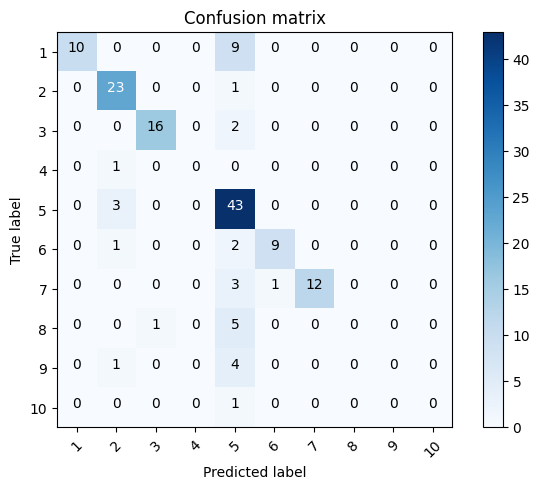

In [91]:
from sklearn.metrics import confusion_matrix
# code from -> SKLEARN Documentation.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("support vector machine")

In [92]:
from sklearn.linear_model import LogisticRegression

logistic regression


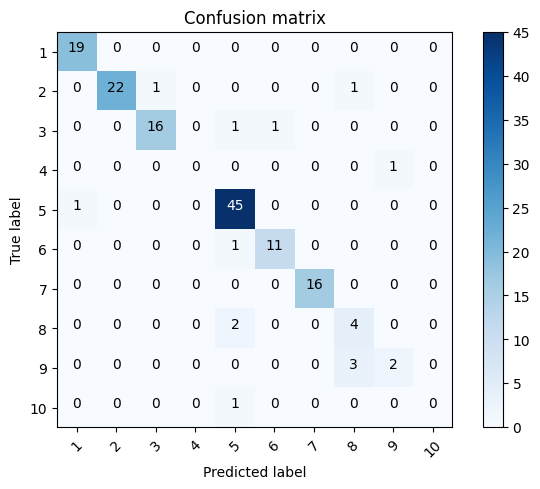

In [93]:
cnf = confusion_matrix(Y_test, lr.predictions)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("logistic regression")

k-nearst neighbour


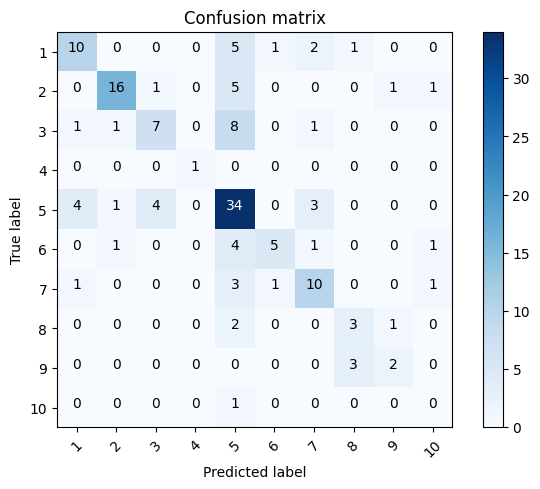

In [94]:
from sklearn.neighbors import KNeighborsClassifier
cnf = confusion_matrix(Y_test, knn.predictions)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("k-nearst neighbour")

decision tree


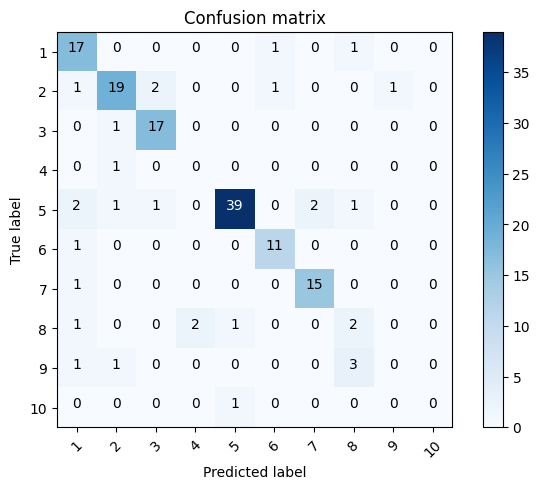

In [95]:
cnf = confusion_matrix(Y_test, tr.predictions)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("decision tree")

random forest


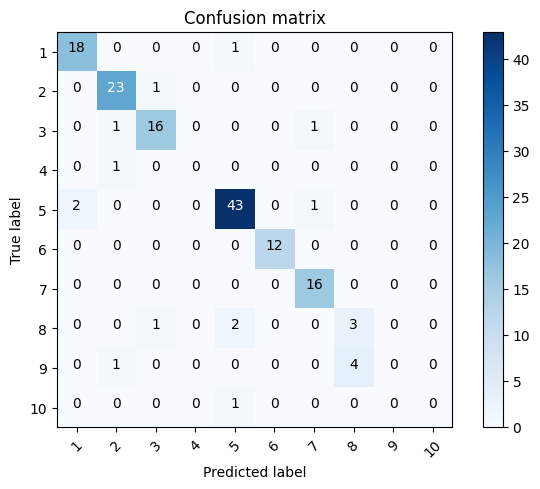

In [96]:
cnf = confusion_matrix(Y_test, rf.predictions)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("random forest")

gradient boosting


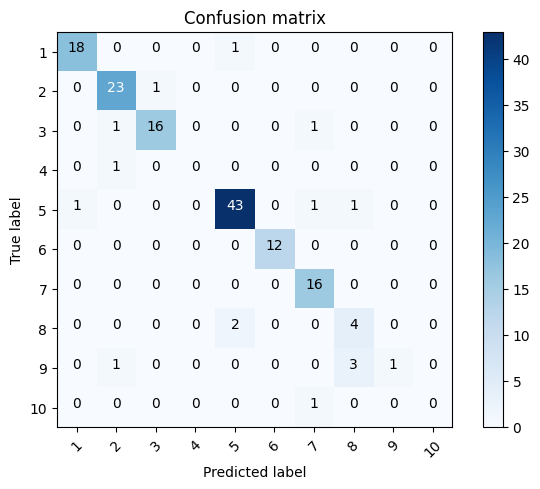

In [97]:
cnf = confusion_matrix(Y_test, gbdt.predictions)
#plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)
print("gradient boosting")

In [98]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
gbdt_best = xgboost.XGBClassifier(**gbdt.grid.best_params_)
svc_best = LinearSVC(**svc.grid.best_params_)
tr_best = DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = KNeighborsClassifier(**knn.grid.best_params_)
lr_best = LogisticRegression(**lr.grid.best_params_)

In [99]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[('rf', rf_best), ('gb', gbdt_best), ('knn', knn_best), ('lr', lr_best)])
votingC = votingC.fit(X_train, Y_train)
predictions = votingC.predict(X_test)
print("Precision : {:.2f}%".format(100 * accuracy_score(Y_test, predictions)))

Precision : 91.22%


In [100]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

In [101]:
objects = ('SVM', 'LR', 'kNN', 'DecisionTree', 'RF', 'GB','voting classifier')
y_pos = np.arange(len(objects))
performance = [75,86.49,64.86,87.16,89.19,87.84,88.51]

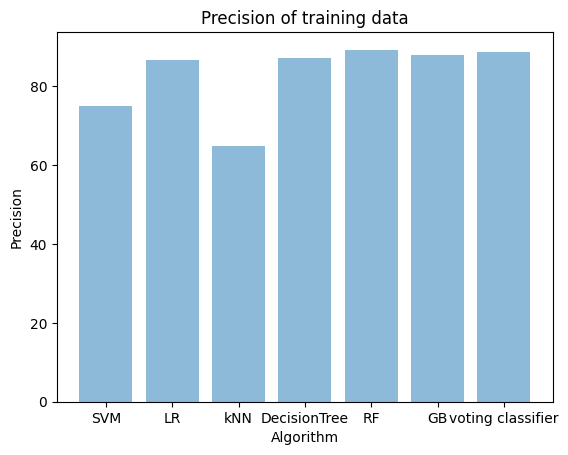

In [102]:
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Precision')
plt.xlabel('Algorithm')
plt.title('Precision of training data')
plt.show()

In [103]:
basket_price = set_test.copy(deep = True)

In [104]:
print(basket_price.columns)

Index(['CustomerID', 'InvoiceNo', 'Basket Price', 'categ_0', 'categ_1',
       'categ_2', 'categ_3', 'categ_4', 'InvoiceDate'],
      dtype='object')


In [105]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

In [106]:
transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

CustomerID
12347    491.34
12357    935.70
12359    317.18
12362    558.22
12380    340.82
          ...  
18241    142.32
18245    234.90
18257    411.30
18272    179.10
18283    478.78
Name: categ_0, Length: 757, dtype: float64

In [107]:
#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

In [108]:
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.570,7595.70,32.343299,12.696657,20.017905,24.271627,10.670511
1,12357,5,6207.67,6207.67,6207.670,31038.35,15.073288,5.089832,18.098578,28.338491,33.399810
2,12359,5,2743.10,2743.10,2743.100,13715.50,11.562830,0.367467,11.550436,25.234224,51.285042
3,12362,25,355.80,786.95,520.008,13000.20,21.469670,5.071460,19.088168,27.144198,27.226504
4,12380,10,446.61,1040.39,743.500,7435.00,22.919973,2.778749,16.698050,26.372562,31.230666


In [109]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']

In [110]:
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

In [111]:
Y = kmeans.predict(scaled_test_matrix)

In [112]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

In [113]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gbdt, 'Gradient Boosting')]

In [114]:
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 72.39 %
______________________________ 
Logostic Regression
Precision: 87.45 %
______________________________ 
k-Nearest Neighbors
Precision: 63.28 %
______________________________ 
Decision Tree
Precision: 74.90 %
______________________________ 
Random Forest
Precision: 84.28 %
______________________________ 
Gradient Boosting
Precision: 84.81 %


In [115]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*accuracy_score(Y, predictions)))

Precision: 86.26 % 


In [116]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('SVM', 'LR', 'kNN', 'DecisionTree', 'RF', 'GB','voting classifier')
y_pos = np.arange(len(objects))
performance = [67.33,82.28,62.43,78.31,83.33,82.28,82.80]

Text(0.5, 1.0, 'Precision of test data')

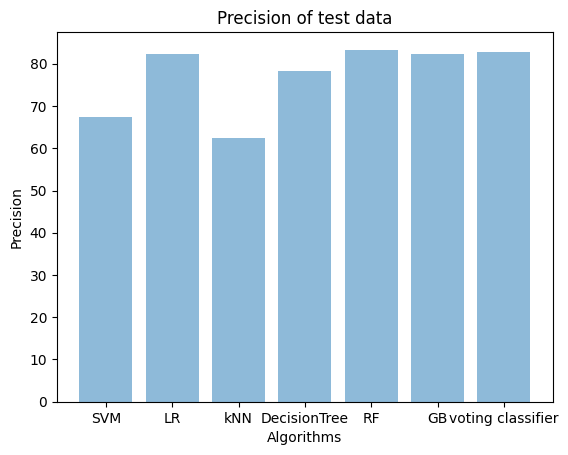

In [117]:
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Precision')
plt.xlabel('Algorithms')
plt.title('Precision of test data')

In [118]:
plt.show()